This notebook is designed to showcase the power of [lvlspy](https://pypi.org/project/lvlspy/) as an API by using it replicate the results from [Gupta and Meyer](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.64.025805). The paper focuses on calculating the equilibration rate between the isomeric state and the ground state of $^{26}\mathrm{Al}$. The methods built into [lvlspy](https://pypi.org/project/lvlspy/) are based on that publication.

To kick things off, we will quietly install any missing packages required for lvlspy and import all the packages required for this notebook. Most are built-in or installed with lvlspy.

In [5]:
#importing system libraries
import sys,subprocess,importlib.util, io, requests

#checking and installing required packages
required  = {'lvlspy','matplotlib'}
installed = {pkg for pkg in required if importlib.util.find_spec(pkg) is not None}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

#import libraries and modules
import numpy as np
import lvlspy.spcoll as lc
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from lvlspy.io import xml
from lvlspy.calculate import isomer, evolve
from IPython.display import HTML, display, Math

Now that all the packages are installed, let us first download an XML file, found on [OSF](https://osf.io/dqzs9), and load into lvlspy

In [6]:
new_coll = lc.SpColl()
xml.update_from_xml(new_coll,io.BytesIO(requests.get('https://osf.io/dqzs9/download').content))
#get the species into separate variable
al26 = new_coll.get()['al26']

Now that the species is loaded from the xml, let's calculate the isomerization rates then graph it

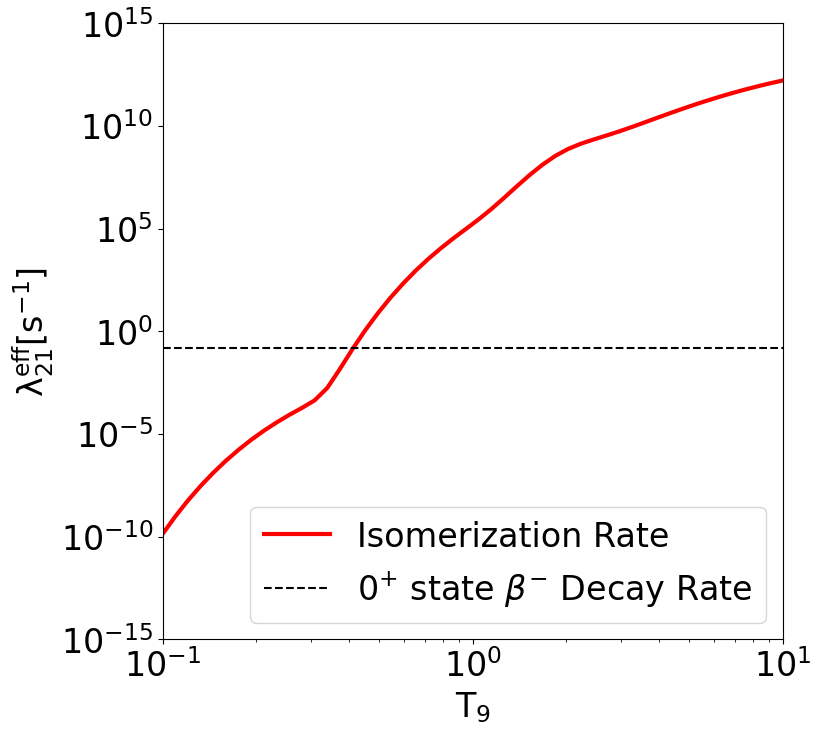

In [7]:
T = np.logspace(8,10) #setting the temperature array

#initializing the rate arrays
l_21 = np.empty(len(T))
l_12 = np.empty(len(T))

for i,t in enumerate(T):
    l_12[i], l_21[i] = isomer.effective_rate(t,al26)

#Set the fontsize and graph
fontsize = 24

plt.figure(figsize = (8,8))
plt.rcParams['font.size'] = fontsize
plt.xscale('log')
plt.yscale('log')

plt.ylim([1.e-15,1.e+15])
plt.xlim([np.min(T)/1e+9,np.max(T)/1e+9])

plt.plot(T/1e+9,l_21,color = 'red',linewidth = 3,label = 'Isomerization Rate')

plt.ylabel(r'$\mathrm{\lambda_{21}^{eff} [s^{-1}]}$')
plt.xlabel(r'$\mathrm{T_{9}}$')

plt.yticks([1e-15,1e-10,1e-5,1e0,1e+5,1e+10,1e+15])

plt.axhline(y = 0.158,ls = '--',color = 'black',label = r'$0^{+}$ state $\beta^{-}$ Decay Rate')#beta decay rate

plt.legend(loc = 'lower right')
plt.show()

As we can see, the figure is a carbon copy of figure 1 from the [paper](https://journals.aps.org/prc/pdf/10.1103/PhysRevC.64.025805) without the removed level, which will be tackled now. Let's say you want see which levels are affecting the isomerization rate the most. lvlspy allows us to remove and levels in an easy manner.

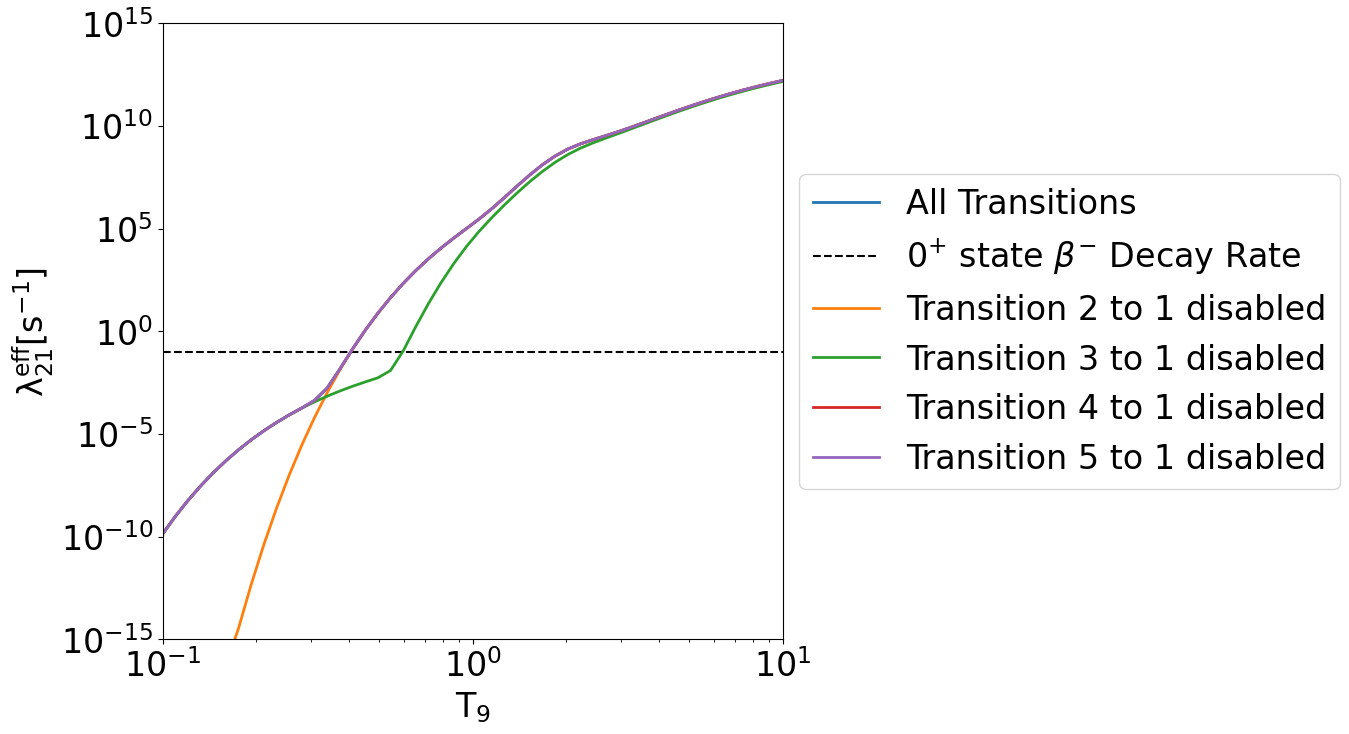

In [8]:
#re-using the previous graph with the original calculation

plt.figure(figsize = (8,8))
plt.rcParams['font.size'] = fontsize
plt.xscale('log')
plt.yscale('log')

plt.ylim([1.e-15,1.e+15])
plt.xlim([np.min(T)/1e+9,np.max(T)/1e+9])

plt.plot(T/1e+9,l_21,linewidth = 2,label = 'All Transitions')

plt.ylabel(r'$\mathrm{\lambda_{21}^{eff} [s^{-1}]}$')
plt.xlabel(r'$\mathrm{T_{9}}$')

plt.yticks([1e-15,1e-10,1e-5,1e0,1e+5,1e+10,1e+15])

plt.axhline(y = 1.e-1,ls = '--',color = 'black',label = r'$0^{+}$ state $\beta^{-}$ Decay Rate')

#removing transitions, graphing the result, then returning it before removing the next
levels = al26.get_levels()
for i in range(2,6):
    t_remove = al26.get_level_to_level_transition(levels[i],levels[1])
    #removing the transition
    al26.remove_transition(t_remove)
    lambda_21_eff = np.empty(len(T))
    lambda_12_eff = np.empty(len(T)) 
    for j,t in enumerate(T):
        lambda_12_eff[j],lambda_21_eff[j] = isomer.effective_rate(t,al26)
    #adding it back after the calculations
    al26.add_transition(t_remove)
    plt.plot(T/1e+9,lambda_21_eff,linewidth = 2,label = 'Transition '+str(i)+ ' to 1 disabled')

plt.legend(loc = 'center left',bbox_to_anchor=(1,0.5))
plt.show()

To clarify the graph, level 1 is the isomeric state and level 0 is the ground state. The transitions that most affect the isomerization rate are 2 $\rightarrow$ 1 and 3 $\rightarrow$ 1. This simple script can be used by theorists to guide experimentalists on which levels to get data on.

Now let's analyze the fugacity of the system. Fugacity here deviates away from the pressure definition it uses in thermodynamics, but the term was appropriated due to its description of a state's abundance likeliness to jump to another state with less fugacity. If two states have the same fugacity, they will not exchange abundances. Equilibrium is established when all states have the same fugacity of one.

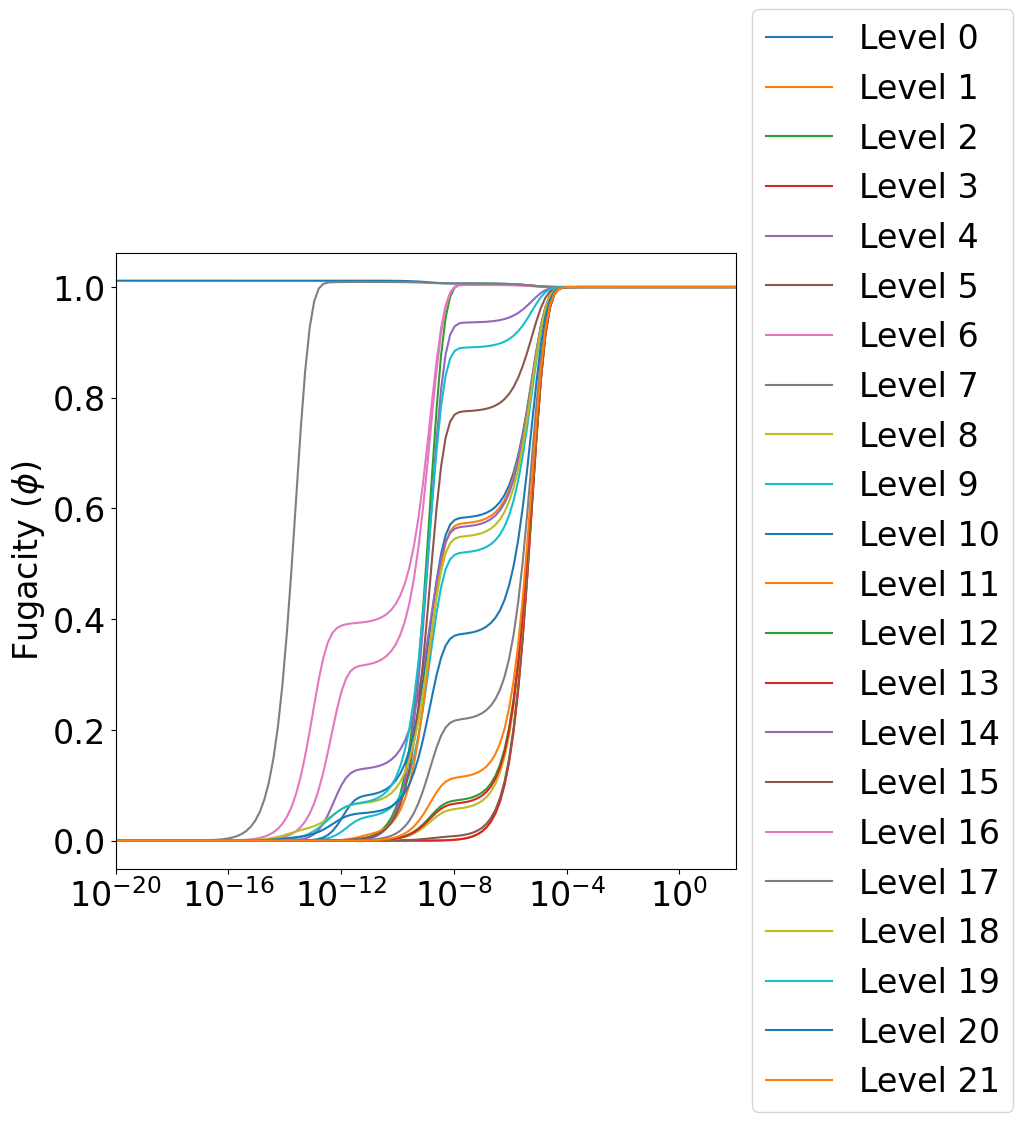

In [15]:
#setting up the initial conditions
y0 = np.zeros(len(levels))
y0[0] = 1.0 #setting the total abundance at the ground state

#resetting the temperature
T = 1e+9 #in K

#setting up the time array to be integrated over
time = np.logspace(-30,2,200)

y,fug = evolve.newton_raphson(al26,T,y0,time) #the method evolves the abundances and fugacities within the same method

#plotting the fugacities

plt.figure(figsize = (8,8))
plt.rcParams['font.size'] = fontsize

for i in range(fug.shape[0]):
    plt.plot(time,fug[i,:],label = 'Level '+str(i))

plt.xscale('log')
#plt.ylim([1e-25,1.25])
plt.xlim([1.e-20, 100])
plt.ylabel(r'Fugacity ($\phi$)')
plt.legend(loc = 'center left',bbox_to_anchor=(1,0.5))

plt.show()